Meilleur C trouvé : 10


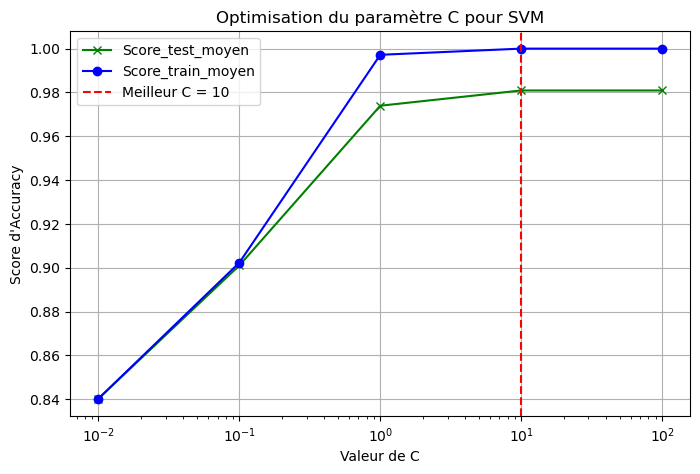

Accuracy on the test set: 0.9919191919191919
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       0.99      1.00      1.00       429

    accuracy                           0.99       495
   macro avg       0.99      0.98      0.98       495
weighted avg       0.99      0.99      0.99       495





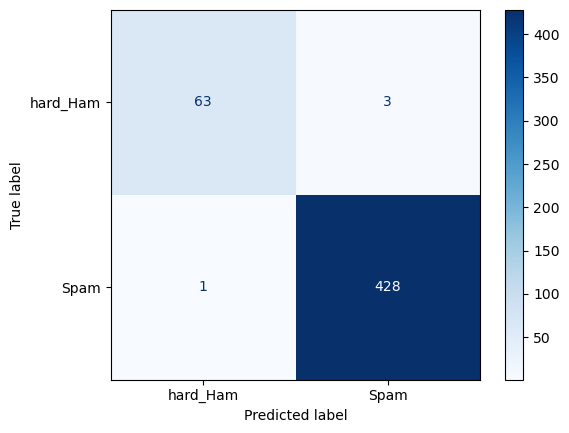

In [145]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import string
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay

# Load files and labels
folder_path_hard_ham = "hard_ham/"
folder_path_spam = "spam_2/"
emails = []
labels = []

for filename in os.listdir(folder_path_hard_ham):
    file_path = os.path.join(folder_path_hard_ham, filename)
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        content = f.read()
        emails.append(content)
        labels.append(0)  
        
for filename in os.listdir(folder_path_spam):
    file_path = os.path.join(folder_path_spam, filename)
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        content = f.read()
        emails.append(content)
        labels.append(1)  
        
# Text cleaning
def clean_text(text):
    text = text.lower()  
    text = re.sub(r"http\S+|www\S+", "", text)  
    text = re.sub(r'\d+', '', text)  
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

emails_cleaned = [clean_text(email) for email in emails]

# Convert texts into numerical vectors
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(emails_cleaned)
y = np.array(labels)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optimization of parameter C with GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Différentes valeurs de C à tester
grid_search = GridSearchCV(SVC(kernel="linear"), param_grid, cv=5, scoring="accuracy",return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur paramètre trouvé
best_C = grid_search.best_params_['C']
print(f"Meilleur C trouvé : {best_C}")

# Best parameter found
cv_results = grid_search.cv_results_
C_values = param_grid['C']
mean_test_scores = cv_results['mean_test_score']
mean_train_scores = cv_results['mean_train_score']

# Plot the evolution of scores as a function of C
plt.figure(figsize=(8,5))
plt.plot(C_values, mean_test_scores, marker='x', linestyle='-', color='g', label="Score_test_moyen")
plt.plot(C_values, mean_train_scores, marker='o', linestyle='-', color='b', label="Score_train_moyen")
plt.axvline(x=best_C, color='r', linestyle='--', label=f"Meilleur C = {best_C}")
plt.xscale('log')  # Échelle logarithmique pour mieux voir les petits C
plt.xlabel("Valeur de C")
plt.ylabel("Score d'Accuracy")
plt.title("Optimisation du paramètre C pour SVM")
plt.legend()
plt.grid()
plt.show()

# Train the final model with the best C
model = SVC(kernel="linear", C=best_C)
model.fit(X_train, y_train)

# Prediction and evaluation on the test set
y_pred = model.predict(X_test)

print("Accuracy on the test set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print()
print()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hard_Ham", "Spam"])
disp.plot(cmap="Blues")
plt.show()

# Save the model and the vectorizer
with open("svm_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
